<a href="https://colab.research.google.com/github/pavelpryadokhin/Transformer-BERT-GPT/blob/main/GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Генерация заголовков к новостям

Обучим GPT писать заголовки к русскоязычных новостным статьям. Для этого мы воспользуемся датасетом [lenta-ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta).

#Предподготовка данных

In [ ]:
!kaggle datasets download yutkin/corpus-of-russian-news-articles-from-lenta
!unzip corpus-of-russian-news-articles-from-lenta.zip -d df

Dataset URL: https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta
License(s): unknown
 99% 580M/584M [00:06<00:00, 96.6MB/s]
100% 584M/584M [00:06<00:00, 99.2MB/s]
Archive:  corpus-of-russian-news-articles-from-lenta.zip
  inflating: df/lenta-ru-news.csv    


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df= pd.read_csv("./df/lenta-ru-news.csv")
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df= df[['title','text','date']]

# Удалим дупликаты и пустые строки
print(df.shape)
df.drop_duplicates(subset='title',inplace=True)
df.dropna(inplace=True)
print(df.shape)

(800975, 3)
(797827, 3)


Рассмотрим количаство заголовков в каждый год

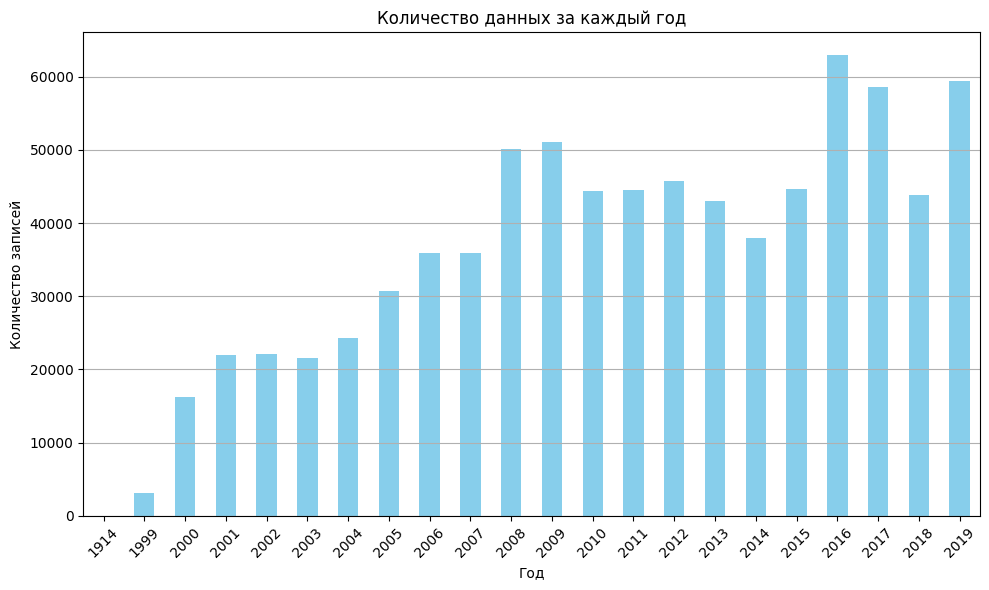

In [ ]:
df['year'] = df['date'].dt.year
count_per_year = df.groupby('year').size()

# Построение графика
plt.figure(figsize=(10, 6))
count_per_year.plot(kind='bar', color='skyblue')
plt.title('Количество данных за каждый год')
plt.xlabel('Год')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

Оставим самые совреенные, выберим последние три года

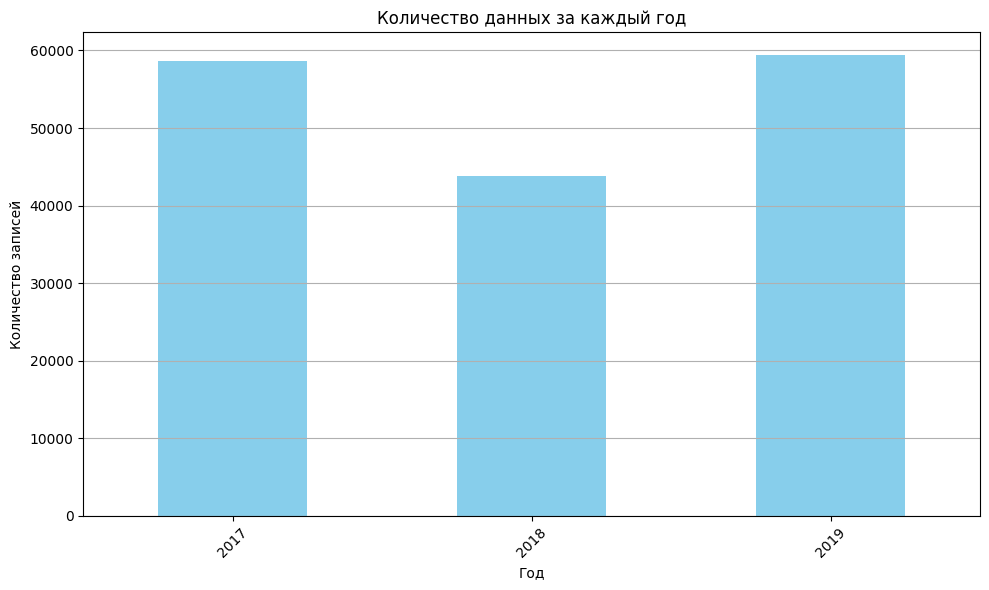

In [ ]:
df_date = df[df['date'].dt.year.isin([2017,2018,2019])]
count_per_year = df_date.groupby('year').size()

# Построение графика
plt.figure(figsize=(10, 6))
count_per_year.plot(kind='bar', color='skyblue')
plt.title('Количество данных за каждый год')
plt.xlabel('Год')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

Удалим ненужные столбцы и перемешаем строчки

In [ ]:
data = df_date.drop(columns=['date','year']).sample(frac=1).reset_index(drop=True)
data.head()

,title,text
0,Украинский депутат назвал телезрителей уродами...,Депутат Верховной Рады от фракции Радикальной ...
1,Турист ударил жену на глазах у прохожих и стал...,Китайского туриста арестовали за драку с женой...
2,Алла Пугачева начала задыхаться на съемках,Алла Пугачева чуть не задохнулась на съемках п...
3,Дания приняла политическое решение по «Северно...,Все политические вопросы Дании к прокладке в е...
4,Организаторы «Евровидения» пригрозили России и...,"Европейский вещательный союз (ЕВС), который ор..."


Заменим переносы строк

In [ ]:
data['text'] = data['text'].str.replace('\\n', ' ')

Ограничим объем данных.Это делает набор данных более управляемым и позволяет сосредоточиться на быстрой итерации и экспериментировании с моделью.

In [ ]:
work_data = data[:15000]

#Дообучение модели

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from pathlib import Path
import torch

DEVICE = torch.device("cuda:0")

DATA_PATH = Path('data/finetune_gpt/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

class FineTuner:
    def __init__(self,
                 model_name='ai-forever/rugpt3small_based_on_gpt2',
                 data_path=DATA_PATH):
        self.data_path = Path(data_path)

        # Инициализация токенизатора и модели
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name).to(DEVICE)




    def prepare_data(self, df):
            """
            Подготовка данных для обучения
            """
            df['input'] = df.apply(
                lambda row: f"<text> {row['text']} {self.tokenizer.eos_token}", axis=1)

            df['output'] = df.apply(
                lambda row: f" <title> {row['title']} {self.tokenizer.eos_token}", axis=1)

            # Подготовка пути для сохранения данных
            dataset_path = self.data_path / 'train_dataset.txt'
            # Запись данных в файл
            with dataset_path.open('w', encoding='utf-8') as file:
                for input_text, target_text in zip(df['input'], df['output']):
                    file.write(input_text + ' ' + target_text + '\n')
            return dataset_path


    def fine_tune(self,
                  dataset_path,
                  output_name='fine_tuned_model',
                  num_train_epochs=2,
                  per_device_train_batch_size=4,
                  learning_rate=5e-5,
                  save_steps=10_000):
            """
            Дообучение модели на заданном датасете.
            """
            train_dataset = TextDataset(
                tokenizer=self.tokenizer,
                file_path=str(dataset_path),
                block_size=256
            )

            data_collator = DataCollatorForLanguageModeling(
                tokenizer=self.tokenizer, mlm=False
            )

            training_args = TrainingArguments(
                output_dir=str(self.data_path / output_name),
                overwrite_output_dir=True,
                num_train_epochs=num_train_epochs,
                per_device_train_batch_size=per_device_train_batch_size,
                save_steps=save_steps,
                learning_rate=learning_rate,
            )

            trainer = Trainer(
                model=self.model,
                args=training_args,
                data_collator=data_collator,
                train_dataset=train_dataset,
            )

            trainer.train()
            # Сохранение обученной модели и токенизатора
            self.model.save_pretrained(str(self.data_path / output_name))
            self.tokenizer.save_pretrained(str(self.data_path / output_name))



In [ ]:
finetuner = FineTuner()
dataset_path = finetuner.prepare_data(work_data)
finetuner.fine_tune(dataset_path,output_name='fine_tuned_model_gpt_2')

Step,Training Loss
500,2.954800
1000,2.925700
1500,2.881300
2000,2.868600
2500,2.850100
3000,2.837500
3500,2.824400
4000,2.791000
4500,2.680000
5000,2.570000


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


#Генерации текста

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from pathlib import Path

class TextGenerator:
    def __init__(self, model_name='fine_tuned_model', data_path=DATA_PATH):

        model_path = Path(data_path) / model_name
        self.tokenizer = GPT2Tokenizer.from_pretrained(str(model_path))
        self.model = GPT2LMHeadModel.from_pretrained(str(model_path))
        self.model.eval()

    def generate_text(self,
                    text,
                    max_length=20,
                    num_return_sequences=1,
                    temperature=8.0,
                    top_k=5,
                    top_p=0.9,
                    do_sample=True):
        """
        Генерация текста на основе заданного начального текста (prompt) и параметров.
        Параметры:
        """
        # Формирование prompt
        prompt_text = f"<text> {text} {self.tokenizer.eos_token} <title>"

        # Кодирование текста в формате, пригодном для модели
        encoded_input = self.tokenizer.encode(prompt_text, return_tensors='pt')

        # Генерация текстов
        outputs = self.model.generate(
            encoded_input,
            max_length=max_length + len(encoded_input[0]),
            num_return_sequences=num_return_sequences,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=do_sample,
            no_repeat_ngram_size=2
        )

        # Декодирование результатов
        all_texts = [self.tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

        # Удаление входных данных из текстов
        prompt_length = len(self.tokenizer.decode(encoded_input[0], skip_special_tokens=True))
        trimmed_texts = [text[prompt_length:] for text in all_texts]

        # Возврат результатов в виде словаря
        return {
            "full_texts": all_texts,
            "generated_texts": trimmed_texts
        }

Проверим работу модели

In [ ]:
generator = TextGenerator(
    model_name='fine_tuned_model_gpt_2',
    data_path=DATA_PATH
)

In [ ]:
text1="""Команда разработчиков Hugging Face объявила о создании открытой версии инструмента Deep Research,
 представленного компанией OpenAI.Этот инструмент, получивший похожее название Open Deep Research,
 является альтернативой разработке OpenAI, которая пока доступна лишь ограниченному кругу пользователей по платной подписке."""

In [ ]:
text2="""Realme совсем скоро представит серию смартфонов P3.
 Недавно устройство с кодовым названием RMX5070, предположительно являющееся Realme P3,
 появилось в базе данных Geekbench, раскрывая ключевые спецификации."""

In [ ]:
generator.generate_text(text1)['generated_texts'][0]


'Hacking Space выпустила открытую версию инструмента  #DeepRack'

In [ ]:
generator.generate_text(text2)['generated_texts'][0]

'Piguet представила новую модель смартфона P2'

#Резюме

В целом, обобщение хорошее и соответствует основной идее новости, однако в тексте есть некоторые неточности. Чтобы добиться более высоких результатов, модель можно дольше обучать и использовать больше данных.